In [ ]:
# !pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

In [ ]:
import sys

from google.colab import drive
drive.mount('/content/drive')
!cp ./drive/Othercomputers/Comp/GNN/dataset.py ./


!pip install virtualenv
!source /content/drive/MyDrive/colab_env/bin/activate;
sys.path.append("/content/drive/MyDrive/colab_env/lib/python3.10/site-packages")

Mounted at /content/drive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 47.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.5/468.5 kB 47.8 MB/s eta 0:00:00


In [ ]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)


2.0.1+cu118


In [ ]:
from torch_geometric.data import DataLoader
from dataset import DessinsDataset


dataset = DessinsDataset('./drive/Othercomputers/Comp/GNN/data', None)
print("Dataset len = ",len(dataset))
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device: {}'.format(device))

Dataset len =  1860
Device: cuda


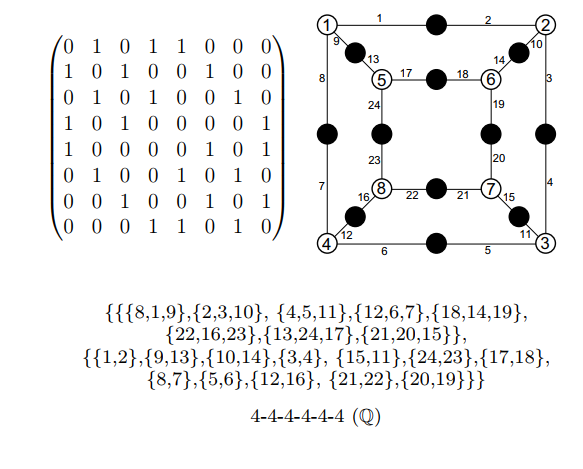

In [ ]:
N = 0
print(dataset[N])
print(dataset[N].edge_index.t()[:15])
print("Edge weights = ", dataset[N].weight)
print(dataset[N].x)
print(dataset[N].y)

Data(edge_index=[2, 48], weight=[48], x=[20, 3], y=[1])
tensor([[ 0,  1],
        [ 0,  2],
        [ 0,  3],
        [ 1,  0],
        [ 1,  9],
        [ 2,  0],
        [ 2,  4],
        [ 3,  0],
        [ 3, 13],
        [ 4,  2],
        [ 4,  5],
        [ 4,  6],
        [ 5,  4],
        [ 5,  7],
        [ 6,  4]])
Edge weights =  tensor([ 8,  1,  9,  8,  7,  1,  2,  9, 13,  2,  3, 10,  3,  4, 10, 14,  4,  5,
        11,  5,  6,  7,  6, 12, 12, 16, 14, 18, 19, 16, 23, 22, 13, 24, 17, 23,
        24, 18, 17, 20, 15, 21, 19, 20, 11, 15, 22, 21])
tensor([[ 8.,  1.,  9.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 3., 10.,  2.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [11.,  4.,  5.],
        [ 0.,  0.,  0.],
        [12.,  6.,  7.],
        [ 0.,  0.,  0.],
        [19., 18., 14.],
        [22., 16., 23.],
        [13., 24., 17.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [20., 15., 21.],
        [ 0.,  

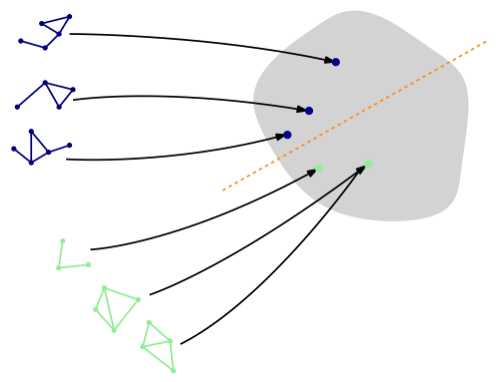

In [ ]:
dataset.y
class_weights = [list(dataset.y).count(i)/len(dataset) for i in range(4)]
print("class_weights =", class_weights)
assert (sum(class_weights) == 1)
c_w = sorted([x for x in class_weights])
c_w = torch.tensor(c_w)


class_weights = [0.4032258064516129, 0.3387096774193548, 0.22580645161290322, 0.03225806451612903]


In [ ]:
dataset = dataset.shuffle()


train_dataset = dataset[:int(len(dataset)*0.8)]
test_dataset = dataset[int(len(dataset)*0.8):]


print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')
print(f'Number of node features:{dataset.num_node_features}')
print(f'Number of classes:{dataset.num_classes}')

Number of training graphs: 1488
Number of test graphs: 372
Number of node features:3
Number of classes:4


Объявим функцию, формирующие батчи для обучений. Присвоим классам вероятности так, чтобы каждый конкретный батч был примерно сбалансирован.

In [ ]:
from torch.utils.data import WeightedRandomSampler

def get_loader(dataset, batch_size):
  # Вычисляем веса
  class_weights = [1/list(dataset.y).count(i) for i in range(4)]
  class_weights = torch.tensor(class_weights)

  #Присваиваем соответствующий вес каждому экземпляру в датасете
  #в соответствии с его классом
  sample_weights = [0] * len(dataset) 
  for idx, data in enumerate(dataset):
    class_weight = class_weights[data.y]
    sample_weights[idx] = class_weight
    
  sampler = WeightedRandomSampler(sample_weights, num_samples=
                                  len(sample_weights), replacement=True)
  loader = DataLoader(dataset, batch_size=batch_size, sampler=sampler)

  return loader


In [ ]:
train_loader = get_loader(train_dataset, batch_size=512)
test_loader = get_loader(test_dataset, batch_size=256)

/content/drive/MyDrive/colab_env/lib/python3.10/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Проверим, что наши батчи на самом деле сбалансированны

In [ ]:
print(list(train_loader)[0])
sample_batch = list(list(train_loader)[0].y)
class_weights = [sample_batch.count(i)/len(sample_batch) for i in range(4)]
print("Class_weights = ",class_weights)

DataBatch(edge_index=[2, 24576], weight=[24576], x=[10240, 3], y=[512], batch=[10240], ptr=[513])
Class_weights =  [0.271484375, 0.26171875, 0.25, 0.216796875]


In [ ]:
from torch.nn import Linear
from torch.nn import BatchNorm1d
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool
from torch_geometric.nn.conv import GraphConv

class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=3, lin_layers=3):
        super(GCN, self).__init__()
        self.last_assigned_token = None

        self.num_layers = num_layers
        self.lin_layers = lin_layers
        self.convs = torch.nn.ModuleList([GCNConv(input_dim,hidden_dim)] + [GCNConv(hidden_dim,hidden_dim)\
                                                                          for i in range(num_layers-1)])
        
        self.batch_norm = BatchNorm1d(hidden_dim)

        #self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
        #self.conv2 = GCNConv(hidden_channels, hidden_channels)
        #self.conv3 = GCNConv(hidden_channels, hidden_channels)
        #self.lin = Linear(hidden_dim, output_dim)
        self.lins = torch.nn.ModuleList([Linear(hidden_dim, hidden_dim)for i in range(lin_layers-1)] + [Linear(hidden_dim, output_dim)])

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()
        for lin in self.lins:
            lin.reset_parameters()

    def forward(self, x, edge_index, weights, batch):
        # 1. Obtain node embeddings 
        for i in range(self.num_layers):
          x = self.convs[i](x, edge_index, edge_weight=weights)
          x = x.relu()

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        x = self.batch_norm(x)

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.6, training=self.training)
        self.last_assigned_token = x
        
        for i in range(self.lin_layers-1):
          x = self.lins[i](x)
          x = x.relu()
          x = F.dropout(x, p=0.25, training=self.training)
        
        x = self.lins[self.lin_layers-1](x) #Final layers

        #x = self.lin(x)
        return x


model = GCN(dataset.num_node_features,hidden_dim=512,output_dim=dataset.num_classes, num_layers=1, lin_layers=3)
print(model)

GCN(
  (convs): ModuleList(
    (0): GCNConv(3, 512)
  )
  (batch_norm): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lins): ModuleList(
    (0-1): 2 x Linear(in_features=512, out_features=512, bias=True)
    (2): Linear(in_features=512, out_features=4, bias=True)
  )
)


In [ ]:
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))
model.reset_parameters()


optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
         #print("Ground = ", data.y[0:10])
         out = model(data.x, data.edge_index, data.weight.float(), data.batch)  # Perform a single forward pass.
         loss = criterion(out, data.y)  # Compute the loss.
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.

def test(loader):
     model.eval()

     correct = 0
     for data in loader:  # Iterate in batches over the training/test dataset.
         out = model(data.x, data.edge_index, data.weight.float(), data.batch)
         #print("LAT = ", model.last_assigned_token)
         #print("model_params = ", list(model.parameters())[0])  
         #print("ground truth = ", data.y)
         
         pred = out.argmax(dim=1)  # Use the class with highest probability.
         #print("prediction = ", pred[0:10])
         correct += int((pred == data.y).sum())  # Check against ground-truth labels.
     return correct / len(loader.dataset)  # Derive ratio of correct predictions.


for epoch in range(1, 100):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')
 

<IPython.core.display.Javascript object>

Epoch: 001, Train Acc: 0.2534, Test Acc: 0.2527
Epoch: 002, Train Acc: 0.3011, Test Acc: 0.2742
Epoch: 003, Train Acc: 0.2466, Test Acc: 0.2581
Epoch: 004, Train Acc: 0.3266, Test Acc: 0.3683
Epoch: 005, Train Acc: 0.3911, Test Acc: 0.4167
Epoch: 006, Train Acc: 0.3851, Test Acc: 0.3710
Epoch: 007, Train Acc: 0.3138, Test Acc: 0.3602
Epoch: 008, Train Acc: 0.4106, Test Acc: 0.4086
Epoch: 009, Train Acc: 0.4523, Test Acc: 0.4946
Epoch: 010, Train Acc: 0.4429, Test Acc: 0.4059
Epoch: 011, Train Acc: 0.4866, Test Acc: 0.4973
Epoch: 012, Train Acc: 0.5296, Test Acc: 0.5134
Epoch: 013, Train Acc: 0.4980, Test Acc: 0.4731
Epoch: 014, Train Acc: 0.5423, Test Acc: 0.5484
Epoch: 015, Train Acc: 0.4765, Test Acc: 0.5457
Epoch: 016, Train Acc: 0.5538, Test Acc: 0.5699
Epoch: 017, Train Acc: 0.5444, Test Acc: 0.4919
Epoch: 018, Train Acc: 0.5551, Test Acc: 0.4839
Epoch: 019, Train Acc: 0.6310, Test Acc: 0.6129
Epoch: 020, Train Acc: 0.6445, Test Acc: 0.6505
Epoch: 021, Train Acc: 0.6156, Test Acc:

KeyboardInterrupt: ignored